In [1]:
# The only variable you need to specify is music library location
misuc_lib_path = "/home/shad/Projects/GanreAnalizer/Samples/mp3"

In [2]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
import pandas as pd
import os
import subprocess
import sys
import requests as req
from pyquery import PyQuery
from datetime import datetime
import json
from itertools import combinations
import math
import sklearn as sk # sklearn.linear_model.LogisticRegression

### There is one part that is written not in Python: conversion mp3 to wav is done via Linux app called "mpg321" in function convert_mp3_to_wav. Everything else is Python.

In [3]:
# General functions and variables
gradual_steps = [10, 50, 100, 500, 
     1000, 5000, 10000, 50000,
     100000, 500000, 1000000, 5000000, 
     10000000, 50000000, 100000000, 500000000, 
     1000000000, 5000000000, 10000000000, 50000000000]

def large_int_print(num):
    final_str = ""
    num_str = list(str(num))
    section_size=0
    while num_str:
        final_str+=num_str.pop()
        if section_size>0 and section_size==2 and len(num_str)!=0:
            final_str+=","
            section_size=0
        else:
            section_size+=1
    return final_str[::-1]

def get_time_left(start_time, total_items, done_items):
    time_spent = datetime.now() - start_time
    if time_spent.seconds==0: return "?"
    rate_ps = done_items / time_spent.seconds
    if rate_ps==0: return "?"
    return print_time(sec_num=round((total_items - done_items)/rate_ps,2))

def print_time(sec_num=None, time_dif=None):
    "Pring nice time from number of seconds or time_dif object"
    if not sec_num:
        if time_dif:
            sec_num = time_dif.seconds
        else:
            print("No values provided for time prointing.")
            return None
    if sec_num < 60:
        return str(round(sec_num)) + "s"
    elif sec_num >= 60 and sec_num < 60*60:
        return (
            str(round(sec_num//60)) + "m" 
            + str(round(sec_num%60)) + "s")
    else:
        return (
            str(round(sec_num//(60*60))) + "h" 
            + str(round((sec_num%(60*60))//60)) + "m" 
            + str(round(sec_num%60)) + "s")

def print_dict(d, sample):
    for i, (k, v) in enumerate(d.items()):
        print(k,":",v)
        if i>=sample:
            break
            
def get_pretty_volume(bytes_num):
    num_size = len(str(bytes_num)) / 3
    def p(val, pow):
        return str(round(val/(1024**pow), 2))
    if num_size > 5: return p(bytes_num,5) + " pb"
    elif num_size > 4: return p(bytes_num,4) + " tb"
    elif num_size > 3: return p(bytes_num,3) + " gb"
    elif num_size > 2: return p(bytes_num,2) + " mb"
    elif num_size > 1: return p(bytes_num,1) + " kb"
    else: return str(bytes_num) + " bytes"
    
def remove_files(lib_path, ext_filter, limit_num):
    log("Removing",ext_filter,"files from",lib_path)
    files = get_all_files(lib_path, ext_filter=ext_filter)
    if limit_num: 
        to_remove_num = limit_num
        log("Found",len(files),"will remove",limit_num,"of them.")
    else:
        to_remove_num = len(files)
        log("Found",len(files),"will remove all of them.")
    freed_space = 0
    for i, file in enumerate(files):
        if i >= to_remove_num: break
        if os.path.isfile(file):
            freed_space += os.path.getsize(file)
            os.remove(file)
        else:
            log(file, "is not a file.")
        if ((i+1)==10 or (i+1)==50 or (i+1)%100==0):
            log("Removed", (i+1), "files. Freed up", get_pretty_volume(freed_space))
    log("Finished cleaning library.\n\tRemoved", to_remove_num, 
        "files. Freed up", get_pretty_volume(freed_space))

In [4]:
def get_all_files(path, ext_filter="MP3"):
    w = os.walk(path)
    # folder / subfolders / files
    all_files = []
    for sw in w:
        all_files += [sw[0] + "/" + x for x in sw[2]]
    files = []
    for f in all_files:
        if f.split(".")[-1].upper() == ext_filter.upper():
            files.append(f)
    return files

def convert_mp3_to_wav(filename_mp3, filename_wav=None):
    cd = os.getcwd() # If filename doesn't contain path, use current directory
    if "/" not in filename_mp3:
        filename_mp3 = cd + "/" + filename_mp3
    filename_wav =  ".".join(filename_mp3.split(".")[0:-1]) + ".wav"
    subprocess.run(["mpg321", "-w", filename_wav, filename_mp3])
    return filename_wav

def get_wav_data_old(filepath, bucket_width=100):
    """ 
    Data of wav file is very much narrowed down to what I want to analyse. 
    So if you want to analyse in your own way, this is the function to change.
    """
    fs, data = wavfile.read(filepath)
    df_data = pd.DataFrame(data)
    df_data['max'] = df_data.max(axis=1)
    df_data['buckets'] = pd.Series(df_data['max']/bucket_width).astype(int)
    bucket_sizes = df_data.groupby('buckets').size()
    bucket_sizes = bucket_sizes.drop(bucket_sizes.idxmax())
    return (bucket_sizes/max(bucket_sizes))

In [5]:
def get_full_wav_data(filepath, **kwargs):
    try:
        fs, data = wavfile.read(filepath)
        df_data = pd.DataFrame(data)
        df_data['max'] = df_data.max(axis=1)
    except Exception as e:
        print("Failed to read",filepath)
        raise
    return df_data

def get_experimental_wav_data(filepath, buckets_num=100):
    try:
        fs, data = wavfile.read(filepath)
        df_data = pd.DataFrame(data)
        df_data['max'] = df_data.max(axis=1)
        #df_data['scale'] = (df_data['max'] + 32768) / (32768 + 32767) # -32768 32767
        if df_data['max'].max() > 32767 or df_data['max'].min() < -32768:
            print("!!! Something wrong with scale !!!")
        df_data['bucket'] = ((df_data['max'] + 32768) / ((32768 + 32767) / buckets_num)).astype('int')
        bucket_sizes = df_data.groupby('bucket').count()
        bucket_sizes = bucket_sizes.drop(bucket_sizes.idxmax())
        bucket_sizes['max'] = bucket_sizes['max'] / bucket_sizes['max'].max()
    except Exception as e:
        print("Failed to read",filepath)
        raise
    return pd.Series(bucket_sizes['max'])

def get_wav_data(filepath, bucket_width=100):
    """ 
    Data of wav file is very much narrowed down to what I want to analyse. 
    So if you want to analyse in your own way, this is the function to change.
    """
    try:
        fs, data = wavfile.read(filepath)
        df_data = pd.DataFrame(data)
        df_data['max'] = df_data.max(axis=1)
        df_data['buckets'] = (df_data['max']/bucket_width).astype('int')
        bucket_sizes = df_data.groupby('buckets').count()
        bucket_sizes = bucket_sizes.drop(bucket_sizes.idxmax())
    except Exception as e:
        print("Failed to read",filepath)
        raise
    return bucket_sizes.index/bucket_sizes['max'].max()

In [6]:
def log(*args):
    print(datetime.now(), " ".join([str(a) for a in args]))
    
def process_library(
        lib_path, 
        proc_func=None, 
        max_files=None, 
        partial_data=None,
        number_of_buckets=100,
        keep_wav=True):
    """
    For all mp3 files in the lib:
        - Convert to wav, if wav doesn't exists
        - Get aggregated data from wav file
    """
    log("Analyzing library...")
    lib_data = pd.DataFrame(columns=list(range(number_of_buckets+1)))
    if not partial_data.empty: 
        lib_data = partial_data
        log("Recieved data of",len(lib_data),"processed files.")
    process_counter = 0
    convert_counter = 0
    skipped = []
    log("Begining library scan...")
    files_to_process = get_all_files(lib_path, ext_filter="MP3")
    log("Library is scanned. Found", len(files_to_process), "mp3 files.")
    if max_files:
        log("Files to process:",max_files)
    else:
        log("Files to process:",len(files_to_process))
    log("Begin library processing...")
    start_time = datetime.now()
    if max_files:
        total_to_proc = max_files
    else:
        total_to_proc = len(all_data_long) - len(files_to_process)
    for mp3_file in files_to_process:
        if mp3_file in lib_data.index:
            continue
        try:
            wav_file = (".".join(mp3_file.split(".")[0:-1]) + ".wav")
            if not os.path.isfile(wav_file):
                # I'm saving wav next to mp3, you can change it here.
                wav_file = convert_mp3_to_wav(mp3_file, wav_file)
                convert_counter+=1
            wav_data = proc_func(wav_file, buckets_num=100) #bucket_width=300)
            # ? Save the thing into sepate json next to wav and mp3 for each song? 
            if not keep_wav:
                os.remove(wav_file)
            lib_data.loc[mp3_file] = wav_data
            process_counter+=1
            if (process_counter in gradual_steps or process_counter%1000==0):
                log("Processed", process_counter,
                    "files, of them converted", convert_counter, "\n\tTime left:", 
                    get_time_left(start_time, total_to_proc, process_counter),
                    " | Dataframe volume:", 
                    get_pretty_volume(sys.getsizeof(lib_data)))
        except Exception as e:
            print("Couldn't process:\n", mp3_file, "\n", wav_file, str(e))
            skipped.append(mp3_file)
        if max_files: 
            if process_counter>=max_files: 
                break
    log("Finished!\n\tSongs processed:", len(lib_data), "of", len(files_to_process),
        "\n\tDataframe valume:", get_pretty_volume(sys.getsizeof(lib_data)),
        "\n\tSkipped:", len(skipped), "files",
        "\n\tTime spent:", print_time(time_dif=datetime.now()-start_time)
        )
    return skipped, lib_data

In [43]:
full_data_dump_file_path = misuc_lib_path + "/Full_Data.json" # Your data dump file will be here
proc_round = 0

def prepare_data(lib_path, dump_path, file_limit):
    global proc_round
    proc_round+=1
    print("Round",proc_round)
    
    # Load if json exists
    all_data = pd.DataFrame() # Dict that contains DataFrame and song names as keys
    if os.path.isfile(dump_path):
        all_data = pd.read_json(dump_path)

    # Keeping whole file paths to be able to manipulate files later
    (skipped_files, all_data) = process_library(
        misuc_lib_path,
        proc_func=get_experimental_wav_data,
        max_files=file_limit,
        partial_data=all_data,
        keep_wav=True)

    # Save results into json
    # Dumping doesn't work for now, due to issut with dumping the whole thing
    all_data.to_json(dump_path)
    print("Data is dumped to",dump_path)
    print("\n\n")
    return all_data

"! Warning ! WAV files takes about 10 times more space then MP3! Beware of free space on your disc."
cycles_to_run = 1
nuber_of_files_per_cycle = 100

for i in range(cycles_to_run): # Iterate to have regular dumps, think this way is more reliable
    all_data_long = prepare_data(
        misuc_lib_path, 
        full_data_dump_file_path, 
        nuber_of_files_per_cycle)
log("Finished processing.")
    
# Clean names (shorten for convinience and memory optimization), saves as a separate dataframe
# Keeping 2 data structures for experimentation convinience, feel free to use only one and remove another!
#all_data_clean_dict = {k[len(misuc_lib_path):]:v for k, v in all_data.items()}
#all_data_df = pd.DataFrame([(k[len(misuc_lib_path):], v) for k, v in all_data.items()])
#print("Lib path is removed from file names, dictionary is converted to DataFrame")

Round 1
2019-06-12 20:06:53.665262 Analyzing library...
2019-06-12 20:06:53.687632 Recieved data of 59 processed files.
2019-06-12 20:06:53.687848 Begining library scan...
2019-06-12 20:06:53.691446 Library is scanned. Found 59 mp3 files.
2019-06-12 20:06:53.691613 Files to process: 100
2019-06-12 20:06:53.691712 Begin library processing...
2019-06-12 20:06:53.697609 Finished!
	Songs processed: 59 of 59 
	Dataframe valume: 57.0 kb 
	Skipped: 0 files 
	Time spent: 0s
Data is dumped to /home/shad/Projects/GanreAnalizer/Samples/mp3/Full_Data.json



2019-06-12 20:06:53.706511 Finished processing.


/home/shad/Projects/GanreAnalizer/Samples/mp3/3 Doors Down - Kryptonite.mp3


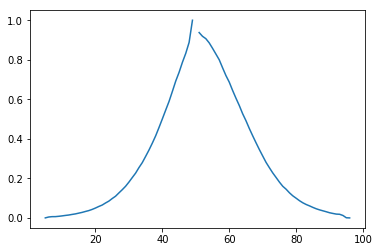

/home/shad/Projects/GanreAnalizer/Samples/mp3/Aerosmith - Living' On The Edge.mp3


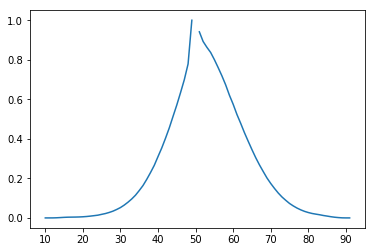

/home/shad/Projects/GanreAnalizer/Samples/mp3/Apocalyptica - No Education.mp3


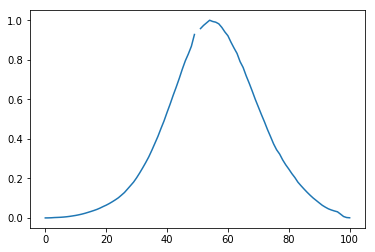

/home/shad/Projects/GanreAnalizer/Samples/mp3/Avantasia - The Scarecrow.mp3


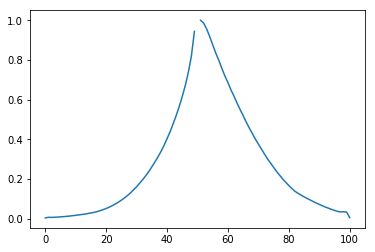

/home/shad/Projects/GanreAnalizer/Samples/mp3/Axel Rudi Pell - Ain't Gonna Win.mp3


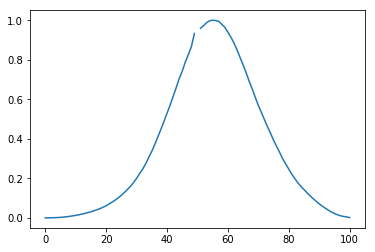

/home/shad/Projects/GanreAnalizer/Samples/mp3/Coal Chamber - Glow.mp3


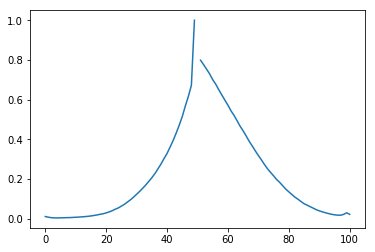

/home/shad/Projects/GanreAnalizer/Samples/mp3/Cradle of Filth - Hurt And Virtue.mp3


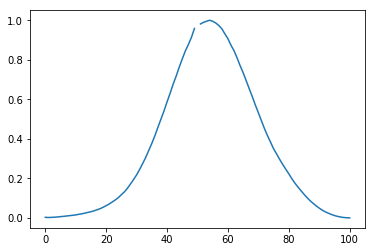

/home/shad/Projects/GanreAnalizer/Samples/mp3/Deepeche Mode - Dream On.MP3


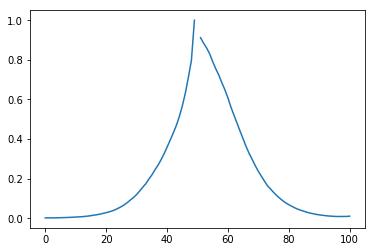

/home/shad/Projects/GanreAnalizer/Samples/mp3/Delibes - D'ou viens-tu Que veux-tu.mp3


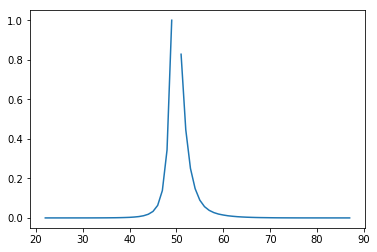

/home/shad/Projects/GanreAnalizer/Samples/mp3/Die Apokalyptischen Reiter - Hammer Oder Amboss.mp3


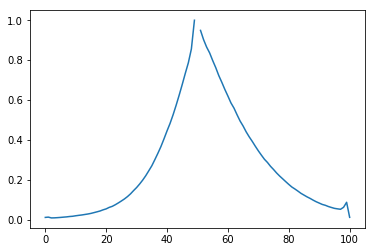

/home/shad/Projects/GanreAnalizer/Samples/mp3/Emily Bear - Hot Peppers.mp3


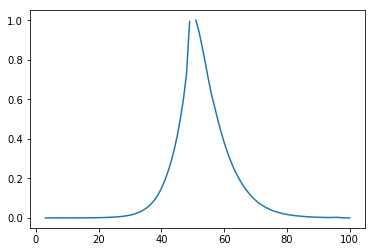

/home/shad/Projects/GanreAnalizer/Samples/mp3/Fischerspooner - Emerge.mp3


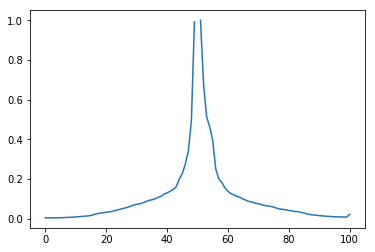

/home/shad/Projects/GanreAnalizer/Samples/mp3/Godsmack - Awake.mp3


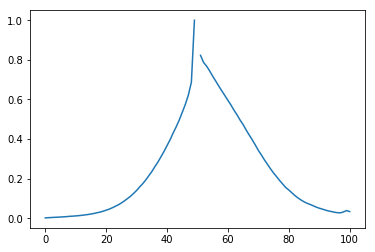

/home/shad/Projects/GanreAnalizer/Samples/mp3/Korn - Freak on a Leash.mp3


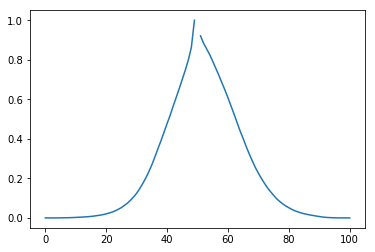

/home/shad/Projects/GanreAnalizer/Samples/mp3/Luciano Pavarotti - Di quella pira - Il trovatore (Verdi).mp3


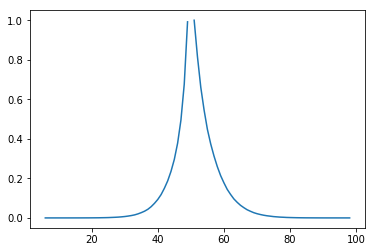

/home/shad/Projects/GanreAnalizer/Samples/mp3/Max Raabe - Kuessen kann man nicht alleine.mp3


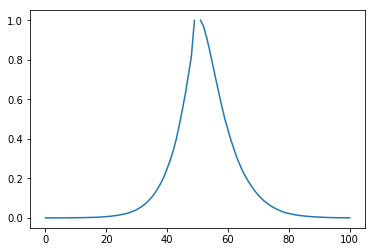

/home/shad/Projects/GanreAnalizer/Samples/mp3/Mozart - Requiem Introitus.mp3


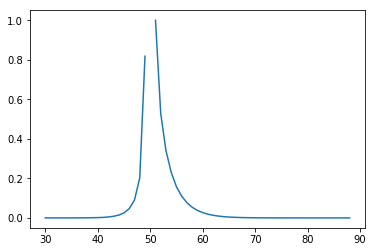

/home/shad/Projects/GanreAnalizer/Samples/mp3/Muse - Sunburn.mp3


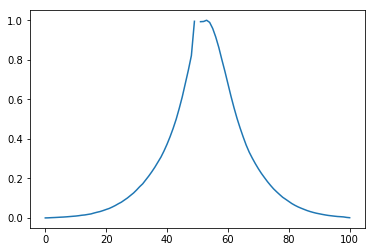

/home/shad/Projects/GanreAnalizer/Samples/mp3/NOFX - Clams Have Feelings Too.mp3


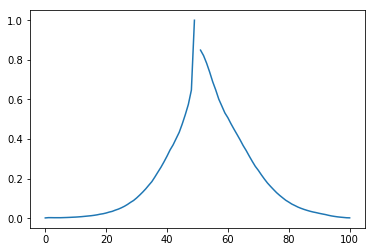

/home/shad/Projects/GanreAnalizer/Samples/mp3/Nirvana - Smells Like Teen Spirit.mp3


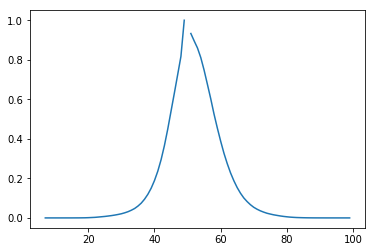

/home/shad/Projects/GanreAnalizer/Samples/mp3/Nonpoint - Endure.mp3


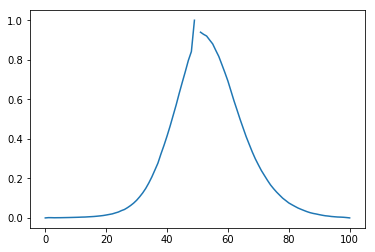

/home/shad/Projects/GanreAnalizer/Samples/mp3/Offsring, The - The End Of The Line.MP3


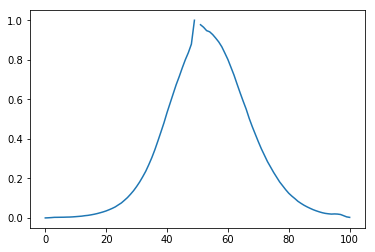

/home/shad/Projects/GanreAnalizer/Samples/mp3/Operatica - Gladiator.mp3


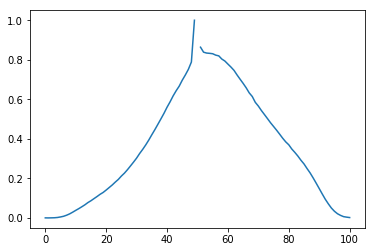

/home/shad/Projects/GanreAnalizer/Samples/mp3/P.O.D, - Alive.mp3


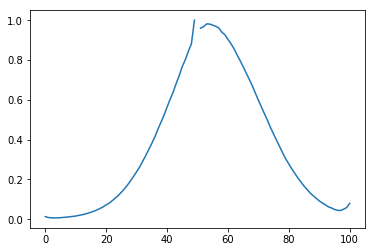

/home/shad/Projects/GanreAnalizer/Samples/mp3/Pennywise - Down Under.mp3


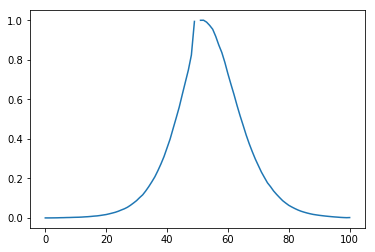

/home/shad/Projects/GanreAnalizer/Samples/mp3/Quixotic - Palms.mp3


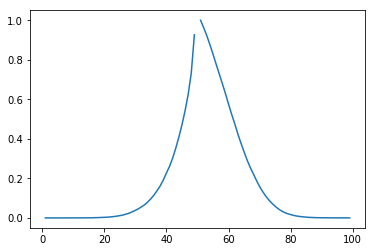

/home/shad/Projects/GanreAnalizer/Samples/mp3/Rage Against the Machine - Take The Power Back.mp3


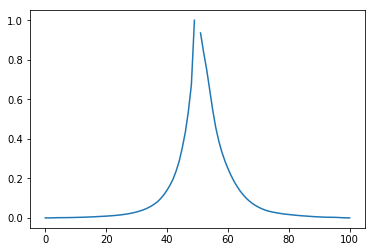

/home/shad/Projects/GanreAnalizer/Samples/mp3/Rammstein - Morgenstern.mp3


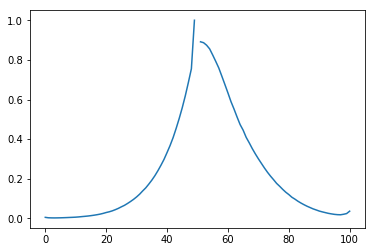

/home/shad/Projects/GanreAnalizer/Samples/mp3/Rhapsody - Dawn Of Victory.mp3


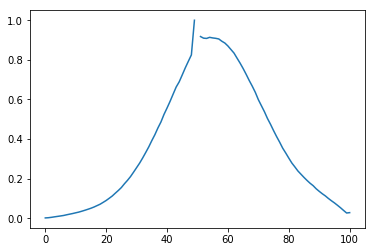

/home/shad/Projects/GanreAnalizer/Samples/mp3/SUM 41 - The Hell Song.mp3


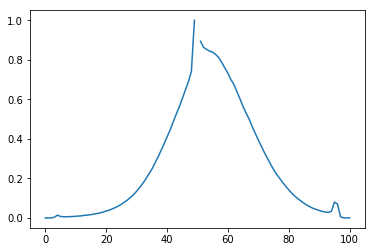

/home/shad/Projects/GanreAnalizer/Samples/mp3/Shadows - Cattanooga Choo Choo Stereo_.mp3


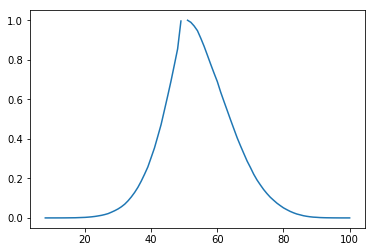

/home/shad/Projects/GanreAnalizer/Samples/mp3/Tenacious D - Master Exploder.mp3


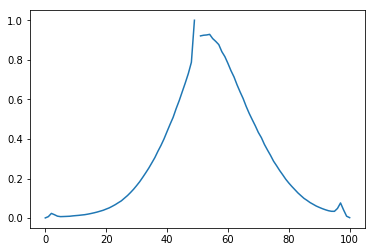

/home/shad/Projects/GanreAnalizer/Samples/mp3/Till Broenner - Bumpin-mycel.mp3


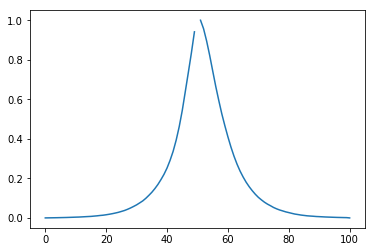

/home/shad/Projects/GanreAnalizer/Samples/mp3/Tim Minchin - Prejudice.mp3


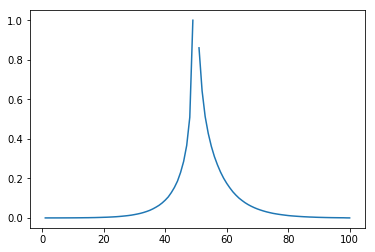

/home/shad/Projects/GanreAnalizer/Samples/mp3/Tito & Tarantula - After Dark.mp3


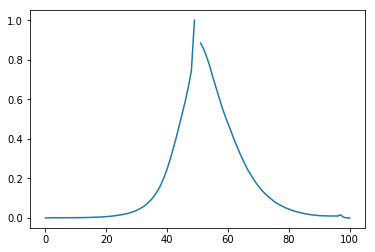

/home/shad/Projects/GanreAnalizer/Samples/mp3/Vivaldi - Август.mp3


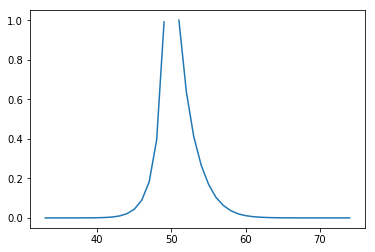

/home/shad/Projects/GanreAnalizer/Samples/mp3/Yann Tiersen - Le Mouline.mp3


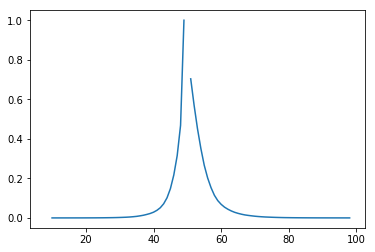

/home/shad/Projects/GanreAnalizer/Samples/mp3/Yes - Roundabout.mp3


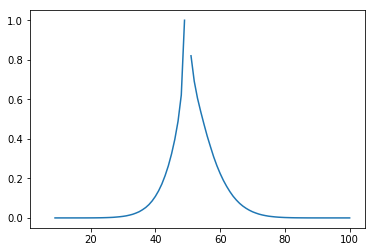

/home/shad/Projects/GanreAnalizer/Samples/mp3/Zombie Hyperdrive - Red eyes.mp3


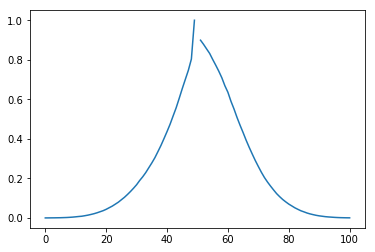

/home/shad/Projects/GanreAnalizer/Samples/mp3/Ария - Потерянный Рай.mp3


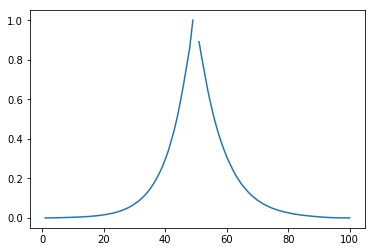

/home/shad/Projects/GanreAnalizer/Samples/mp3/Nightwish - The Kinslayer.mp3


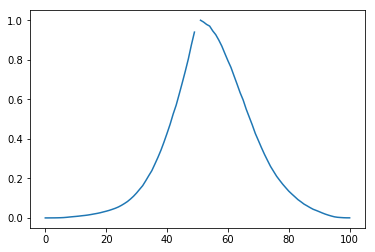

/home/shad/Projects/GanreAnalizer/Samples/mp3/Phantom of the Opera - Overture.mp3


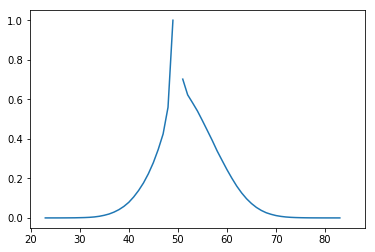

/home/shad/Projects/GanreAnalizer/Samples/mp3/Finntroll - Jaktens Tid.mp3


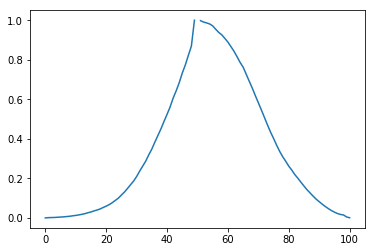

/home/shad/Projects/GanreAnalizer/Samples/mp3/ACDC - T.N.T..mp3


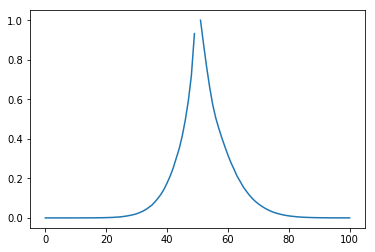

/home/shad/Projects/GanreAnalizer/Samples/mp3/Turisas - Battle metal.mp3


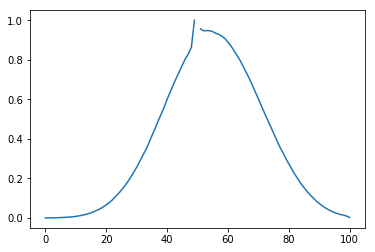

/home/shad/Projects/GanreAnalizer/Samples/mp3/Airbourne - Too Much, Too Young, Too Fast.mp3


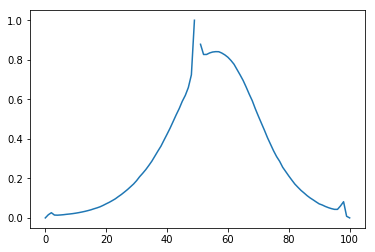

/home/shad/Projects/GanreAnalizer/Samples/mp3/Touch and Go - Would You.mp3


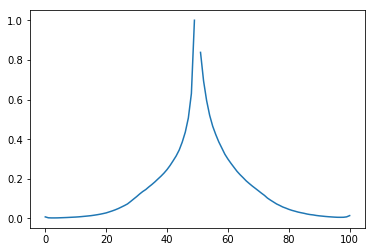

/home/shad/Projects/GanreAnalizer/Samples/mp3/Gavin Rossdale - Adrenaline.mp3


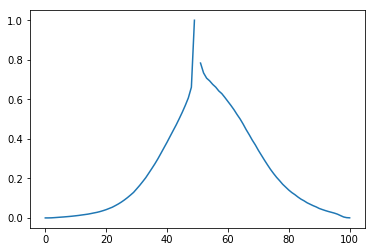

/home/shad/Projects/GanreAnalizer/Samples/mp3/Sepultura - Roots Bloody Roots.mp3


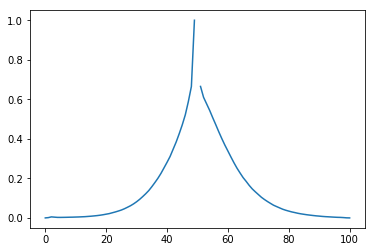

/home/shad/Projects/GanreAnalizer/Samples/mp3/van Canto - Kings of Metal.mp3


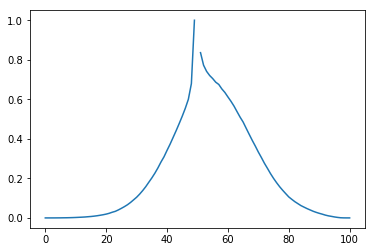

/home/shad/Projects/GanreAnalizer/Samples/mp3/Ensiferum - Blood Is The Price Of Glory.mp3


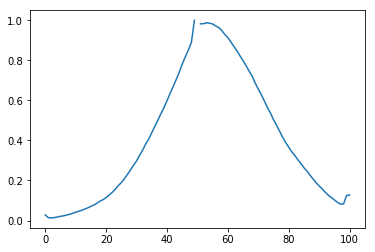

/home/shad/Projects/GanreAnalizer/Samples/mp3/Robert Miles - Children (Dream Version).mp3


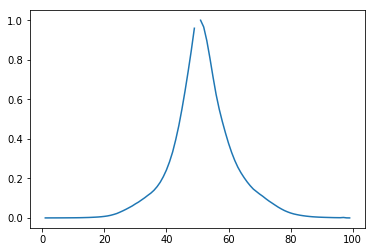

/home/shad/Projects/GanreAnalizer/Samples/mp3/Bullet for my Valentine - Truth Hurts.mp3


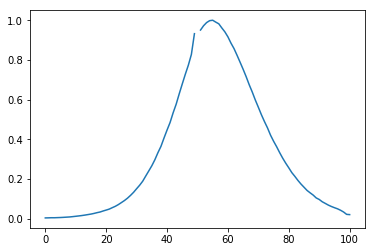

/home/shad/Projects/GanreAnalizer/Samples/mp3/Dragonborn.mp3


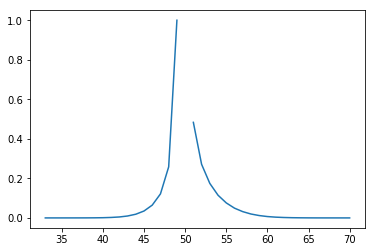

/home/shad/Projects/GanreAnalizer/Samples/mp3/Blink 182 - First date.mp3


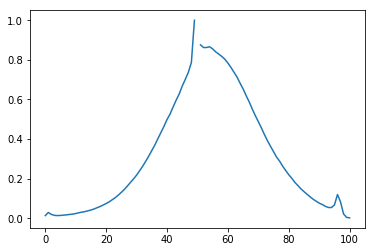

/home/shad/Projects/GanreAnalizer/Samples/mp3/Audioslave - Your Time Has Come.mp3


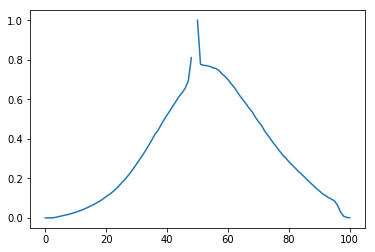

/home/shad/Projects/GanreAnalizer/Samples/mp3/Black Sabbath - Paranoid.mp3


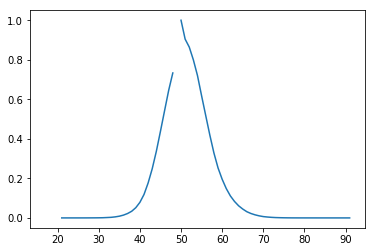

/home/shad/Projects/GanreAnalizer/Samples/mp3/Emma Shapplin - The Inferno.mp3


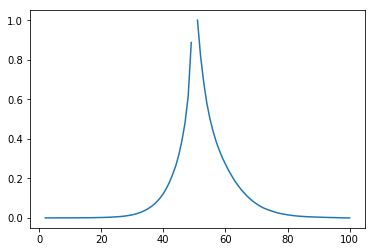

/home/shad/Projects/GanreAnalizer/Samples/mp3/Children of Bodom - Towards Dead End.mp3


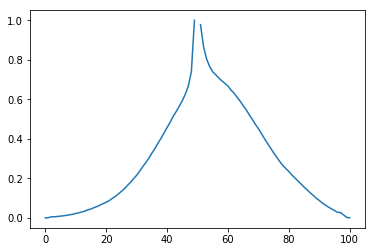

In [8]:
# Build song diagrams
for index, row in all_data_long.iterrows():
    print(index)
    plt.plot(row)
    plt.show()
    

In [9]:
def compare_all_songs(buckets_df, sample_size=None):
    "Compares songs. Approx 100.000 songs a minute for 100-column df"
    log("Begining comparison...")
    all_combinations = pd.DataFrame(
        data=[[s1,s2,None] for s1, s2 in combinations(list(buckets_df.index)[:sample_size], 2)], 
        columns=["Song1", "Song2", "Distance"])
    #all_combinations["Distance"] = pd.to_numeric(all_combinations["Distance"])
    
    if sample_size and sample_size < len(buckets_df):
        total_to_proc = sample_size
    else:
        total_to_proc = len(buckets_df)
    log("Of",total_to_proc,"of songs, number of unique pairs:",
        large_int_print(len(all_combinations)))
    start_time = datetime.now()
    for index, row in all_combinations.iterrows():
        if index+1 in gradual_steps[4:] or (index+1)%1000000==0: 
            log("Processed", large_int_print(index+1), 
                "rows. Approximate time left:",
                get_time_left(start_time, len(all_combinations), index+1))
            
            # Size of DF?
            
        song1_name = row[0] 
        song2_name = row[1]
        if song1_name == song2_name:
            print("Comparing to itself :(")
        song1_data = all_data_long.loc[song1_name].copy()
        song2_data = all_data_long.loc[song2_name].copy()
        #all_combinations.iloc[index]["Distance"] = sum_of_abs_of_arrays(
        #    pd.Series(song1_data - song2_data))
        all_combinations.iloc[index]["Distance"] = abs((song1_data - song2_data)).sum()
    all_combinations["Distance"] = pd.to_numeric(all_combinations["Distance"])
    log("Completed comparison of",total_to_proc,"songs.",
       "Time spent:", print_time(time_dif=datetime.now()-start_time))
    return all_combinations

#comb = compare_all_songs(all_data_long, sample_size=10)


In [15]:
no_nans_data = all_data_long.fillna(all_data_long.mean())
comb = compare_all_songs(no_nans_data)
comb.to_csv(misuc_lib_path + "/comaprison_result.csv")


#s = comb["Song1"]
#comb["Song1"] = comb["Song1"][len("/media/shad/DATA/MuzAnalysis/"):]
#comb.iloc[1]

2019-06-12 19:07:15.081616 Begining comparison...
2019-06-12 19:07:15.083385 Of 59 of songs, number of unique pairs: 1,711
2019-06-12 19:07:15.742661 Processed 1,000 rows. Approximate time left: ?
2019-06-12 19:07:16.213178 Completed comparison of 59 songs. Time spent: 1s


In [17]:
no_nans_data

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
/home/shad/Projects/GanreAnalizer/Samples/mp3/3 Doors Down - Kryptonite.mp3,0.002900,3.174937e-03,0.003672,0.003423,0.003954,0.000179,4.607494e-03,0.006437,6.551493e-03,8.199548e-03,...,0.022646,0.019394,0.018452,0.012394,0.000831,0.000054,0.016510,0.013092,1.117032e-02,9.502851e-03
/home/shad/Projects/GanreAnalizer/Samples/mp3/Aerosmith - Living' On The Edge.mp3,0.002900,3.174937e-03,0.003672,0.003423,0.003954,0.004363,5.001485e-03,0.006017,6.840420e-03,8.092603e-03,...,0.000001,0.030744,0.026610,0.023269,0.021293,0.019687,0.016510,0.013092,1.117032e-02,9.502851e-03
/home/shad/Projects/GanreAnalizer/Samples/mp3/Apocalyptica - No Education.mp3,0.000021,1.978631e-04,0.000779,0.001863,0.002482,0.003199,4.352988e-03,0.005849,7.807347e-03,1.016522e-02,...,0.063922,0.054515,0.046073,0.040067,0.035141,0.030928,0.019333,0.007164,1.970386e-03,6.925208e-04
/home/shad/Projects/GanreAnalizer/Samples/mp3/Avantasia - The Scarecrow.mp3,0.004230,7.210282e-03,0.006878,0.007413,0.008448,0.009413,1.071746e-02,0.012159,1.357253e-02,1.550060e-02,...,0.065942,0.058905,0.053470,0.047359,0.042182,0.037343,0.034395,0.035240,3.372272e-02,5.962593e-03
/home/shad/Projects/GanreAnalizer/Samples/mp3/Axel Rudi Pell - Ain't Gonna Win.mp3,0.000272,6.019559e-04,0.000888,0.001355,0.002282,0.003102,4.423676e-03,0.006104,8.337790e-03,1.053563e-02,...,0.060070,0.049405,0.039544,0.030344,0.022530,0.016247,0.011104,0.007711,5.414804e-03,1.968256e-03
/home/shad/Projects/GanreAnalizer/Samples/mp3/Coal Chamber - Glow.mp3,0.010485,7.098702e-03,0.004574,0.003545,0.003442,0.003760,4.166690e-03,0.004763,5.050195e-03,5.919765e-03,...,0.034303,0.029713,0.025530,0.021954,0.019200,0.017341,0.017185,0.021037,2.921700e-02,2.141316e-02
/home/shad/Projects/GanreAnalizer/Samples/mp3/Cradle of Filth - Hurt And Virtue.mp3,0.003504,2.613143e-03,0.003185,0.004016,0.005344,0.007056,8.336100e-03,0.010240,1.200748e-02,1.362977e-02,...,0.039759,0.031173,0.024407,0.017853,0.012554,0.008356,0.005116,0.002788,1.360232e-03,4.991676e-04
/home/shad/Projects/GanreAnalizer/Samples/mp3/Deepeche Mode - Dream On.MP3,0.001326,1.439901e-03,0.001601,0.001684,0.001898,0.002432,2.973487e-03,0.003293,4.018281e-03,4.788129e-03,...,0.014766,0.012892,0.011122,0.010175,0.009008,0.008464,0.008627,0.008770,8.786043e-03,1.014041e-02
/home/shad/Projects/GanreAnalizer/Samples/mp3/Delibes - D'ou viens-tu Que veux-tu.mp3,0.002900,3.174937e-03,0.003672,0.003423,0.003954,0.004363,5.001485e-03,0.006017,6.840420e-03,8.092603e-03,...,0.034108,0.030744,0.026610,0.023269,0.021293,0.019687,0.016510,0.013092,1.117032e-02,9.502851e-03
/home/shad/Projects/GanreAnalizer/Samples/mp3/Die Apokalyptischen Reiter - Hammer Oder Amboss.mp3,0.011916,1.339695e-02,0.009412,0.009789,0.010746,0.011916,1.329336e-02,0.014597,1.649254e-02,1.770518e-02,...,0.077009,0.072695,0.066555,0.061808,0.057329,0.054889,0.052680,0.062646,8.774592e-02,1.229400e-02


In [17]:
# Grouping comparisons
comb = compare_all_songs(all_data_long, sample_size=100)
for i in range(1,3):
    comb["Song" + str(i)] = pd.Series(
        comb["Song" + str(i)]).str.slice(
            start=len(misuc_lib_path))

for i in range(1,3):
    comb["Song" + str(i)] = pd.Series(
        comb["Song" + str(i)]).str.split("/", expand=True)

#gr = (columns=["Song1","Song2","Mean Distance","Number of songs"])
gr = pd.DataFrame(comb.groupby(["Song1","Song2"])["Distance"].mean())
gr["Number of pairs"] = comb.groupby(["Song1","Song2"])["Distance"].count()
#gr = comb.groupby(["Song1", "Song2"], as_index=True, axis=1)
#(comb.groupby(["Song1", "Song2"], index=False)).mean()["Distance"]
gr

2019-06-12 10:05:02.253295 Begining comparison...
2019-06-12 10:05:02.256011 Of 5 of songs, number of unique pairs: 10
2019-06-12 10:05:02.294377 Completed comparison of 5 songs. Time spent: 0s


,,Distance,Number of pairs
Song1,Song2,,
,,10.952909,10


In [18]:
gr.to_csv(misuc_lib_path + "/comaprison_result.csv")

In [11]:
comb.to_csv(misuc_lib_path + "/comaprison_result.csv")

In [ ]:
comb.to_json(misuc_lib_path + "/comaprison_data.json")

In [ ]:
logreg = sk.linear_model.LogisticRegression(
    penalty='l2',
    dual=False, 
    tol=0.0001, 
    C=1.0, 
    fit_intercept=True, 
    intercept_scaling=1, 
    class_weight=None, 
    random_state=None, 
    solver='warn', 
    max_iter=100, 
    multi_class='warn', 
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=None
    )

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
/home/shad/Projects/GanreAnalizer/Samples/mp3/3 Doors Down - Kryptonite.mp3,0.002900,3.174937e-03,0.003672,0.003423,0.003954,0.000179,4.607494e-03,0.006437,6.551493e-03,8.199548e-03,...,0.022646,0.019394,0.018452,0.012394,0.000831,0.000054,0.016510,0.013092,1.117032e-02,9.502851e-03
/home/shad/Projects/GanreAnalizer/Samples/mp3/Aerosmith - Living' On The Edge.mp3,0.002900,3.174937e-03,0.003672,0.003423,0.003954,0.004363,5.001485e-03,0.006017,6.840420e-03,8.092603e-03,...,0.000001,0.030744,0.026610,0.023269,0.021293,0.019687,0.016510,0.013092,1.117032e-02,9.502851e-03
/home/shad/Projects/GanreAnalizer/Samples/mp3/Apocalyptica - No Education.mp3,0.000021,1.978631e-04,0.000779,0.001863,0.002482,0.003199,4.352988e-03,0.005849,7.807347e-03,1.016522e-02,...,0.063922,0.054515,0.046073,0.040067,0.035141,0.030928,0.019333,0.007164,1.970386e-03,6.925208e-04
/home/shad/Projects/GanreAnalizer/Samples/mp3/Avantasia - The Scarecrow.mp3,0.004230,7.210282e-03,0.006878,0.007413,0.008448,0.009413,1.071746e-02,0.012159,1.357253e-02,1.550060e-02,...,0.065942,0.058905,0.053470,0.047359,0.042182,0.037343,0.034395,0.035240,3.372272e-02,5.962593e-03
/home/shad/Projects/GanreAnalizer/Samples/mp3/Axel Rudi Pell - Ain't Gonna Win.mp3,0.000272,6.019559e-04,0.000888,0.001355,0.002282,0.003102,4.423676e-03,0.006104,8.337790e-03,1.053563e-02,...,0.060070,0.049405,0.039544,0.030344,0.022530,0.016247,0.011104,0.007711,5.414804e-03,1.968256e-03
/home/shad/Projects/GanreAnalizer/Samples/mp3/Coal Chamber - Glow.mp3,0.010485,7.098702e-03,0.004574,0.003545,0.003442,0.003760,4.166690e-03,0.004763,5.050195e-03,5.919765e-03,...,0.034303,0.029713,0.025530,0.021954,0.019200,0.017341,0.017185,0.021037,2.921700e-02,2.141316e-02
/home/shad/Projects/GanreAnalizer/Samples/mp3/Cradle of Filth - Hurt And Virtue.mp3,0.003504,2.613143e-03,0.003185,0.004016,0.005344,0.007056,8.336100e-03,0.010240,1.200748e-02,1.362977e-02,...,0.039759,0.031173,0.024407,0.017853,0.012554,0.008356,0.005116,0.002788,1.360232e-03,4.991676e-04
/home/shad/Projects/GanreAnalizer/Samples/mp3/Deepeche Mode - Dream On.MP3,0.001326,1.439901e-03,0.001601,0.001684,0.001898,0.002432,2.973487e-03,0.003293,4.018281e-03,4.788129e-03,...,0.014766,0.012892,0.011122,0.010175,0.009008,0.008464,0.008627,0.008770,8.786043e-03,1.014041e-02
/home/shad/Projects/GanreAnalizer/Samples/mp3/Delibes - D'ou viens-tu Que veux-tu.mp3,0.002900,3.174937e-03,0.003672,0.003423,0.003954,0.004363,5.001485e-03,0.006017,6.840420e-03,8.092603e-03,...,0.034108,0.030744,0.026610,0.023269,0.021293,0.019687,0.016510,0.013092,1.117032e-02,9.502851e-03
/home/shad/Projects/GanreAnalizer/Samples/mp3/Die Apokalyptischen Reiter - Hammer Oder Amboss.mp3,0.011916,1.339695e-02,0.009412,0.009789,0.010746,0.011916,1.329336e-02,0.014597,1.649254e-02,1.770518e-02,...,0.077009,0.072695,0.066555,0.061808,0.057329,0.054889,0.052680,0.062646,8.774592e-02,1.229400e-02


## Clusterization

In [23]:
from sklearn.cluster import AgglomerativeClustering

cl = AgglomerativeClustering(n_clusters=8).fit(no_nans_data)


"""
sk.cluster.AgglomerativeClustering(
    n_clusters=2, 
    affinity='euclidean', 
    memory=None, 
    connectivity=None, 
    compute_full_tree='auto', 
    linkage='ward', 
    distance_threshold=None)
"""

"\nsk.cluster.AgglomerativeClustering(\n    n_clusters=2, \n    affinity='euclidean', \n    memory=None, \n    connectivity=None, \n    compute_full_tree='auto', \n    linkage='ward', \n    distance_threshold=None)\n"

In [44]:
all_data_long

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
/home/shad/Projects/GanreAnalizer/Samples/mp3/3 Doors Down - Kryptonite.mp3,NaN,NaN,NaN,NaN,NaN,0.000179,4.607494e-03,0.006437,6.551493e-03,8.199548e-03,...,0.022646,0.019394,0.018452,0.012394,0.000831,0.000054,NaN,NaN,NaN,NaN
/home/shad/Projects/GanreAnalizer/Samples/mp3/ACDC - T.N.T..mp3,0.000008,7.558900e-06,0.000011,0.000017,0.000012,0.000011,1.965300e-05,0.000041,5.140020e-05,7.861210e-05,...,0.000788,0.000620,0.000537,0.000382,0.000317,0.000246,0.000192,0.000145,1.995537e-04,1.224534e-04
/home/shad/Projects/GanreAnalizer/Samples/mp3/Aerosmith - Living' On The Edge.mp3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"/home/shad/Projects/GanreAnalizer/Samples/mp3/Airbourne - Too Much, Too Young, Too Fast.mp3",0.000234,1.632564e-02,0.026470,0.014736,0.014089,0.015145,1.654674e-02,0.018501,2.008759e-02,2.194744e-02,...,0.065579,0.058247,0.052245,0.047283,0.043505,0.043417,0.060988,0.082132,8.531863e-03,2.958840e-04
/home/shad/Projects/GanreAnalizer/Samples/mp3/Apocalyptica - No Education.mp3,0.000021,1.978631e-04,0.000779,0.001863,0.002482,0.003199,4.352988e-03,0.005849,7.807347e-03,1.016522e-02,...,0.063922,0.054515,0.046073,0.040067,0.035141,0.030928,0.019333,0.007164,1.970386e-03,6.925208e-04
/home/shad/Projects/GanreAnalizer/Samples/mp3/Audioslave - Your Time Has Come.mp3,0.000009,1.812230e-05,0.000260,0.001767,0.005201,0.008741,1.220842e-02,0.015618,1.963858e-02,2.378558e-02,...,0.123084,0.113561,0.102950,0.095209,0.086012,0.064799,0.029911,0.008916,2.491822e-03,9.333007e-04
/home/shad/Projects/GanreAnalizer/Samples/mp3/Avantasia - The Scarecrow.mp3,0.004230,7.210282e-03,0.006878,0.007413,0.008448,0.009413,1.071746e-02,0.012159,1.357253e-02,1.550060e-02,...,0.065942,0.058905,0.053470,0.047359,0.042182,0.037343,0.034395,0.035240,3.372272e-02,5.962593e-03
/home/shad/Projects/GanreAnalizer/Samples/mp3/Axel Rudi Pell - Ain't Gonna Win.mp3,0.000272,6.019559e-04,0.000888,0.001355,0.002282,0.003102,4.423676e-03,0.006104,8.337790e-03,1.053563e-02,...,0.060070,0.049405,0.039544,0.030344,0.022530,0.016247,0.011104,0.007711,5.414804e-03,1.968256e-03
/home/shad/Projects/GanreAnalizer/Samples/mp3/Black Sabbath - Paranoid.mp3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
/home/shad/Projects/GanreAnalizer/Samples/mp3/Blink 182 - First date.mp3,0.013192,2.901736e-02,0.019389,0.014535,0.013414,0.014129,1.570793e-02,0.017134,1.907017e-02,2.077964e-02,...,0.069255,0.060394,0.054380,0.053896,0.067009,0.119571,0.082648,0.021395,4.373973e-03,1.609168e-03


In [45]:
all_data_short = all_data_long.copy()
all_data_short.index = index=[i[len(misuc_lib_path)+1:] for i in all_data_long.index]
all_data_short

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
3 Doors Down - Kryptonite.mp3,NaN,NaN,NaN,NaN,NaN,0.000179,4.607494e-03,0.006437,6.551493e-03,8.199548e-03,...,0.022646,0.019394,0.018452,0.012394,0.000831,0.000054,NaN,NaN,NaN,NaN
ACDC - T.N.T..mp3,0.000008,7.558900e-06,0.000011,0.000017,0.000012,0.000011,1.965300e-05,0.000041,5.140020e-05,7.861210e-05,...,0.000788,0.000620,0.000537,0.000382,0.000317,0.000246,0.000192,0.000145,1.995537e-04,1.224534e-04
Aerosmith - Living' On The Edge.mp3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Airbourne - Too Much, Too Young, Too Fast.mp3",0.000234,1.632564e-02,0.026470,0.014736,0.014089,0.015145,1.654674e-02,0.018501,2.008759e-02,2.194744e-02,...,0.065579,0.058247,0.052245,0.047283,0.043505,0.043417,0.060988,0.082132,8.531863e-03,2.958840e-04
Apocalyptica - No Education.mp3,0.000021,1.978631e-04,0.000779,0.001863,0.002482,0.003199,4.352988e-03,0.005849,7.807347e-03,1.016522e-02,...,0.063922,0.054515,0.046073,0.040067,0.035141,0.030928,0.019333,0.007164,1.970386e-03,6.925208e-04
Audioslave - Your Time Has Come.mp3,0.000009,1.812230e-05,0.000260,0.001767,0.005201,0.008741,1.220842e-02,0.015618,1.963858e-02,2.378558e-02,...,0.123084,0.113561,0.102950,0.095209,0.086012,0.064799,0.029911,0.008916,2.491822e-03,9.333007e-04
Avantasia - The Scarecrow.mp3,0.004230,7.210282e-03,0.006878,0.007413,0.008448,0.009413,1.071746e-02,0.012159,1.357253e-02,1.550060e-02,...,0.065942,0.058905,0.053470,0.047359,0.042182,0.037343,0.034395,0.035240,3.372272e-02,5.962593e-03
Axel Rudi Pell - Ain't Gonna Win.mp3,0.000272,6.019559e-04,0.000888,0.001355,0.002282,0.003102,4.423676e-03,0.006104,8.337790e-03,1.053563e-02,...,0.060070,0.049405,0.039544,0.030344,0.022530,0.016247,0.011104,0.007711,5.414804e-03,1.968256e-03
Black Sabbath - Paranoid.mp3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Blink 182 - First date.mp3,0.013192,2.901736e-02,0.019389,0.014535,0.013414,0.014129,1.570793e-02,0.017134,1.907017e-02,2.077964e-02,...,0.069255,0.060394,0.054380,0.053896,0.067009,0.119571,0.082648,0.021395,4.373973e-03,1.609168e-03


In [46]:
all_data_short["cluster"] = cl.labels_
pd.DataFrame(all_data_short["cluster"]).sort_values('cluster') # all_data_long, no_nans_data

,cluster
Muse - Sunburn.mp3,0
Yes - Roundabout.mp3,0
Yann Tiersen - Le Mouline.mp3,0
Sepultura - Roots Bloody Roots.mp3,0
Rage Against the Machine - Take The Power Back.mp3,0
Nightwish - The Kinslayer.mp3,0
Finntroll - Jaktens Tid.mp3,0
Blink 182 - First date.mp3,0
Ария - Потерянный Рай.mp3,0
"Airbourne - Too Much, Too Young, Too Fast.mp3",0


In [ ]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')

plt.show()

# Experiment starting from here
### Everythin that follows is in very raw state

In [ ]:
chart_sample = 3 # Limit sample of songs to build charts
for k, v in all_data.items():
    if chart_sample > 0:
        chart_sample-=1
        print(k)
        plt.plot(v)
        plt.show()
    else:
        break

In [ ]:
def make_combinations(data_dict):
    # Make a list of all combinations, to have list of comparisons.
    prodj = combinations(list(data_dict.keys()), 2)
    prodj = list(prodj)
    print("Number of possible comparisons:", len(list(prodj)))
    return prodj

#comb = make_combinations(all_data)

In [ ]:
import pprint
# Check out all combination pairs
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(comb)

In [ ]:
def compare_songs(prodj, data_dict):
    print("Pairs to compare: " + str(len(prodj)))
    comparing_data = pd.DataFrame(columns=['song1','song2','dif'])
    comparing_data["dif"] = pd.to_numeric(comparing_data["dif"]) 

    comparing_counter = 0
    for song1_name, song2_name in prodj:
        try:
            if song1_name == song2_name:
                print("Comparing to itself :(")
            if song1_name[0] == song2_name[0]:
                pass
            
            result = pd.concat([
                data_dict[song1_name],
                data_dict[song2_name]
                ], 
                keys=[0,1],
                axis=1, join='outer').fillna(0) #join_axes=[song1_data.index]
            result['dif'] = (abs(result[0] - result[1])).astype('float')
            res_list = [song1_name, song2_name, sum(result['dif'])]
            if res_list[2] != 0:
                comparing_data.loc[len(comparing_data)] = res_list
        except Exception as e:
            print("Issue with", song1_name, "or", song1_name)
            print("Error:", str(e))
            break
        comparing_counter+=1
        if (comparing_counter%100000==0 
            or comparing_counter==10 
            or comparing_counter==50
            or comparing_counter==100
            or comparing_counter==500
            or comparing_counter==1000
            or comparing_counter==10000
            or comparing_counter==50000
           ):
            print(str(datetime.now()) + " Compared " + str(comparing_counter) + " songs.")

    print(str(datetime.now()) + " Compared " + str(comparing_counter) + " pairs of songs.")
    print("Finished!")
    return comparing_data

# Should rewrite to use only one data structure
data_sample = {}
sample_size = None
if sample_size:
    for f,d in all_data.items():
        data_sample[f] = d
        sample_size-=1
        if sample_size <= 0:
            break
else:
    data_sample = all_data
            
comp = compare_songs(make_combinations(data_sample), data_sample)
print("\nThe lower value, the closer style of songs.")
#print(comp[0:3])

In [ ]:
comp[0:3]
#dif_bands = comp.filter(comp['song1'].split("/")[0] != comp['song1'].split("/")[1]) 
comp.sort_values('dif').head(100).to_csv(path_or_buf=misuc_lib_path + "/top100.csv")

In [ ]:
import networkx as nx
G = G=nx.from_numpy_matrix(comparing_data)
nx.draw(G)

## Product join of all elements

In [ ]:
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4)


cut_path = len(misuc_lib_path)
cd = [(c[0][cut_path:], c[1][cut_path:], c[2]) for c in comparing_data]
sizes = [c[2] for c in cd]
size_buckets = {}
for s in sizes:
    ns = int(s/10)
    if ns in size_buckets:
        size_buckets[ns] += 1
    else:
        size_buckets[ns] = 1

pp.pprint(size_buckets)

In [ ]:
len(top_simil)
top_simil.to_csv(index=True, path_or_buf=(misuc_lib_path + "/Comparing.csv"))

# Web parser

In [ ]:

r = req.get('https://lyrics.fandom.com/wiki/3_Doors_Down')


In [ ]:
print(r.content)

In [ ]:
# Getting ganres
b1 = bands[0]
url = "https://lyrics.fandom.com/wiki/" + "_".join(b1.split(" "))
r = req.get(url)
print(r.content)

In [ ]:
# Parsing out ganres
pq = PyQuery(r.content)
print(pq)

</div></div><div class="css-table-cell">
<p class="highlight"><b>Genres:</b></p><div>
<ul><li><a href="/wiki/Category:Genre/Alternative_Rock" title="Category:Genre/Alternative Rock">Alternative Rock</a>
</li><li><a href="/wiki/Category:Genre/Pop_Rock" title="Category:Genre/Pop Rock">Pop Rock</a>
</li><li><a href="/wiki/Category:Genre/Post-Grunge" title="Category:Genre/Post-Grunge">Post-Grunge</a>
</li></ul>
</div>